# Shelter Animal Outcomes

In this notebook we will try to predict the future of the animals that get into shelters.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import collections
import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder


%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
display(train.head(),
        train.isnull().sum(),
        test.isnull().sum())

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

In [4]:
train.loc[train['SexuponOutcome'].isnull(), 'SexuponOutcome'] = 'Unknown'

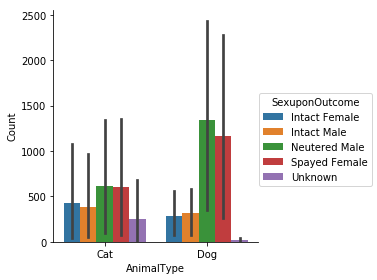

In [5]:
animal_sex_outcomes = train.groupby(['AnimalType', 'SexuponOutcome']).OutcomeType.value_counts()
animal_sex_outcomes.name = 'Count'
animal_sex_outcomes = animal_sex_outcomes.reset_index()
a_s_o_fp = sns.factorplot(x='AnimalType',
                          y='Count',
                          hue='SexuponOutcome',
                          data=animal_sex_outcomes,
                          kind='bar',)

In [6]:
train_id, test_id = train['AnimalID'], test['ID']
# train.drop('AnimalID', axis=1, inplace=True)
# test.drop('ID', axis=1, inplace=True)

In [42]:
breedcnt = dict()

breed_noise_pat = re.compile('\\s*\\b(mix|shorthair|australian|swiss|mexican|' +
                             'spanish|american|british|english|belgian|jack|russel|l|old|' +
                             'west|german|rat|great|shorthair|longhair|mediumhair|eng|toy|' +
                             'medium|hair|russel|yorkshire|miniature|pale|gray|red|' +
                             'orange|tiger|smoke|blue|yellow|tabby|calico|point|tick|brindle|' +
                             'tan|black|)\\b\\s*', re.IGNORECASE)

def simplify_breed(breed):
    return breed_noise_pat.sub('', breed)

def breed_is_(breed, pat):
    def clf(x):
        return 1 * x['Breed'].str.match(pat)
    return clf

breed_props = [('Domestic', re.compile('.*domestic.*', re.IGNORECASE),),
               ('Longhair', re.compile('.*long\\s*hair.*', re.IGNORECASE),),
               ('Mix', re.compile('.*(mix|/).*', re.IGNORECASE))]

class BreedPreprocessor(BaseEstimator):
    def __init__(self, max_breeds=6, col='Breed', rare_name='Rare'):
        self.max_breeds = max_breeds
        self.col = col
        self.rare = rare_name
        self.breed_cnt_ = None
        
    def fit(self, X, y=None):
        print('[I] Fitting breeds')
        breedcnt = defaultdict(lambda: 0)
        for breeds in X[self.col]:
            for breed in breeds.split('/'):
                breed = simplify_breed(breed)
                breedcnt[breed] += 1
        self.breed_cnt_ = pd.Series(breedcnt).sort_values(ascending=False)
        self.top_ = set(self.breed_cnt_.index[:self.max_breeds - 1])
        return self
    
    def _extract_breed(self, breeds):
        for breed in breeds.split('/'):
            breed = simplify_breed(breed)
            if breed in self.top_:
                return breed
        return self.rare
    
    def transform(self, X):
        print('[I] Transforming breeds')
        X = X.copy()
        X[self.col] = X[self.col].apply(lambda x: self._extract_breed(x))
        X = X.assign(**{
            breed_prop: breed_is_(breed_prop, pat)
            for breed_prop, pat in breed_props
        })
        return X
        
breeds = BreedPreprocessor()
breeds.fit(pd.concat((train, test)))
breeds.top_

[I] Fitting breeds


{'Chihuahua', 'Domestic', 'LabradorRetriever', 'PitBull', 'Shepherd'}

In [43]:


# TODO:
# 1.  extract "basic" colors
# 2.  treat space-separated basic colors as polycolored patterns
def is_monocolor(x):
    return x['Color'].str.contains('/')

class ColorPreprocessor(BaseEstimator):
    def __init__(self, max_colors=5, col='Color'):
        self.max_colors = max_colors
        self.col = col
        self.color_cnt_ = None
        self.top_ = None
    def fit(self, X, y=None):
        print('[I] Fitting colors')
        clrcnt = defaultdict(lambda: 0)
        for clrs in X[self.col]:
            for clr in clrs.split('/'):
                clrcnt[clr] += 1
        self.color_cnt_ = pd.Series(clrcnt).sort_values(ascending=False)
        self.top_ = set(self.color_cnt_.index[:self.max_colors-1])
        return self
        
    def _extract_color(self, colors):
        for color in colors.split('/'):
            color = simplify_breed(color)
            if color in self.top_: return color
        return 'Rare'
    
    def transform(self, X):
        print('[I] Transforming colors')
        X = X.copy()
        X = X.assign(Monocolor = is_monocolor)
        X[self.col] = X[self.col].apply(self._extract_color)
        return X
        
colors = ColorPreprocessor()
colors.fit(pd.concat((train, test)))
colors.top_

[I] Fitting colors


{'Black', 'Brown', 'Tan', 'White'}

In [44]:
adopted = breeds.transform(train).loc[breeds.transform(train)['OutcomeType'] == 'Adoption']
adopted.groupby(['AnimalType', 'Breed'])['AgeuponOutcome'].describe()

[I] Transforming breeds
[I] Transforming breeds


count unique       top  freq
AnimalType Breed                                         
Cat        Domestic           3927     28  2 months  1691
           Rare                345     27  2 months   108
Dog        Chihuahua          1192     26    1 year   273
           LabradorRetriever   980     24  2 months   203
           PitBull             669     22    1 year   173
           Rare               3136     27    1 year   630
           Shepherd            520     24  2 months    95

In [45]:
died = breeds.transform(train).loc[breeds.transform(train)['OutcomeType'] == 'Died']
died.groupby(['AnimalType', 'Breed'])['AgeuponOutcome'].describe()

[I] Transforming breeds
[I] Transforming breeds


count unique       top freq
AnimalType Breed                                        
Cat        Domestic            139     26   1 month   42
           Rare                  8      6   1 month    3
Dog        Chihuahua            16     11   2 years    3
           LabradorRetriever     4      3  10 years    2
           PitBull               8      7  3 months    2
           Rare                 19     13   2 years    4
           Shepherd              3      3   5 years    1

In [46]:
def age_to_ymd(x):
    if x <= 30:
        return (0, 0, x)
    elif x < 365:
        return (0, x//30, 0)
    else:
        return (int(x/365.25), 0, 0)

def purify_ages(ages):
    days_in_unit = {
    'day': 1,
    'days': 1,
    'week': 7,
    'weeks': 7,
    'month': 30,
    'months': 30,
    'years': 365.25,
    'year': 365.25
    }
    def strage_to_days(age):
        if not isinstance(age, str): return float('nan')
        age = age.split(' ')
        return int(age[0]) * days_in_unit[age[1]]
    ages = ages.map(strage_to_days)
    return ages

class AgePreprocessor(BaseEstimator):
    def __init__(self, col='AgeuponOutcome', groupby=['Breed', 'SexuponOutcome',], estimator=np.median):
        self.ages_ = None
        self.groupby = groupby
        self.estimator = np.median
        self.col = col
        
    def fit(self, X, y=None):
        X = X.copy()
        X[self.col] = purify_ages(X[self.col])
        groups = X.groupby(self.groupby)
        self.ages_ = groups[self.col].agg(collections.OrderedDict([
            ('size', np.size,),
            ('estimate', self.estimator,),
        ]))
        return self
    
    def transform(self, X):
        print('[I] Transforming ages')
        X = X.copy()
        specific_age_pat = re.compile('.*(week|day).*', re.IGNORECASE)
        X['SpecificAge'] = X[self.col].str.match(specific_age_pat)
        X[self.col] = purify_ages(X[self.col])
        missing = X.loc[X[self.col].isnull()]
        groups = missing.groupby(self.groupby)
        for i, g in groups:
            missing[self.col] = missing[self.col].fillna(self.ages_.loc[i, 'estimate'])
        X.loc[X[self.col].isnull(), self.col] = missing[self.col]
        
        X['AgeYears'], X['AgeMonths'], X['AgeDays'] = zip(
            *X[self.col].apply(age_to_ymd)
        )
        return X
        
full = pd.concat((train, test,), keys=[1, 2])
ages = AgePreprocessor()
ages.fit(full)
ages.transform(train)['AgeuponOutcome'].isnull().sum()

/home/god/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


[I] Transforming ages


/home/god/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0

In [47]:
import dateutil

In [48]:
def extract_mon_wd_h(x):
    x = dateutil.parser.parse(x)
    return (x.month, x.day, x.weekday(), x.hour)


class ArrivalDatePreprocessor(BaseEstimator):
    def __init__(self, col='DateTime'):
        self.col = col
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        print('[I] Transforming arrival dates')
        X = X.copy()
        X['ArrMonth'], X['ArrMonthday'], X['ArrWeekday'], X['ArrHour'] = (
            zip(*X[self.col].apply(extract_mon_wd_h))
        )
        return X
arrivals = ArrivalDatePreprocessor()
arrivals.fit(train)

ArrivalDatePreprocessor(col='DateTime')

In [49]:
class SimpleAnimalFeatures(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('[I] Engineering simple features')
        sterilized_pat = re.compile('.*(neutered|spayed).*', re.IGNORECASE)
        female_pat = re.compile('.*\\b(female)\\b.*', re.IGNORECASE)  
        male_pat = re.compile('.*\\b(male)\\b.*', re.IGNORECASE)
        
        X = X.copy()
        X['Sterilized'] = 1 * X['SexuponOutcome'].str.match(sterilized_pat)
        X['Male'] = 1 * X['SexuponOutcome'].str.match(male_pat)
        X['Female'] = 1 * X['SexuponOutcome'].str.match(female_pat)
        X['Name'] = 1 * X['Name'].notnull()
        return X.drop('SexuponOutcome', axis=1)

In [50]:
class DropGarbage(sklearn.base.BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('[I] Droping crap')
        return X.drop([
            'ID', 'AnimalID',
            'DateTime',
            'OutcomeType',
            'OutcomeSubtype'],
            axis=1,
            errors='ignore')

In [51]:
class TextvarsSeqEncoder(BaseEstimator):
    def __init__(self, textvars=['AnimalType', 'Breed', 'Color']):
        self.textvars = textvars
        self.enc_ = defaultdict(sklearn.preprocessing.LabelEncoder)

    def fit(self, X, y=None):
        print('[I] Fitting text var encoders')
        for v in self.textvars:
            self.enc_[v].fit(X[v])
        return self
    
    def transform(self, X):
        print('[I] Encoding text vars')
        X = X.copy()
        for v in self.textvars:
            X[v] = self.enc_[v].transform(X[v])
        return X

In [52]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [53]:
prepr_pipe = Pipeline([
    ('breed', breeds),
    ('color', colors),
    ('age', ages),
    ('arrivals', arrivals),
    ('simplefeats', SimpleAnimalFeatures()),
    ('drop', DropGarbage()),
    ('textenc', TextvarsSeqEncoder())
])

In [54]:
prepr_pipe.fit(pd.concat((train, test,), keys=(1,2)))

[I] Fitting breeds
[I] Transforming breeds
[I] Fitting colors
[I] Transforming colors


/home/god/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/home/god/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[I] Transforming ages
[I] Transforming arrival dates
[I] Engineering simple features
[I] Droping crap
[I] Fitting text var encoders


Pipeline(steps=[('breed', BreedPreprocessor(col='Breed', max_breeds=6, rare_name=None)), ('color', ColorPreprocessor(col='Color', max_colors=5)), ('age', AgePreprocessor(col='AgeuponOutcome',
        estimator=<function median at 0x7f2fd007b400>,
        groupby=['Breed', 'SexuponOutcome'])), ('arrivals', ArrivalDatePreprocessor(col='DateTime')), ('simplefeats', SimpleAnimalFeatures()), ('drop', DropGarbage()), ('textenc', TextvarsSeqEncoder(textvars=['AnimalType', 'Breed', 'Color']))])

In [55]:
X, y = prepr_pipe.transform(train), train['OutcomeType']
display(X.head(), y.head())

[I] Transforming breeds
[I] Transforming colors
[I] Transforming ages


/home/god/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[I] Transforming arrival dates
[I] Engineering simple features
[I] Droping crap
[I] Encoding text vars


,Name,AnimalType,AgeuponOutcome,Breed,Color,Domestic,Longhair,Mix,Monocolor,SpecificAge,AgeYears,AgeMonths,AgeDays,ArrMonth,ArrMonthday,ArrWeekday,ArrHour,Sterilized,Male,Female
0,1,1,365.25,4,0,0,0,0,True,False,1,0.0,0.0,2,12,2,18,1,1,0
1,1,0,365.25,1,1,1,0,0,False,False,1,0.0,0.0,10,13,6,12,1,0,1
2,1,1,730.50,3,2,0,0,0,True,False,2,0.0,0.0,1,31,5,12,1,1,0
3,0,0,21.00,1,1,1,0,0,False,True,0,0.0,21.0,7,11,4,19,0,1,0
4,0,1,730.50,4,1,0,0,0,False,False,2,0.0,0.0,11,15,4,12,1,1,0


0    Return_to_owner
1         Euthanasia
2           Adoption
3           Transfer
4           Transfer
Name: OutcomeType, dtype: object

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rfc = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV

In [ ]:
rfecv = RFECV(rfc,
              cv=StratifiedKFold(3),
              scoring='neg_log_loss',
              verbose=2)

In [ ]:
rfecv.fit(X, y)

In [ ]:
plt.plot(pd.DataFrame(rfecv.grid_scores_))

In [ ]:
rfc = rfecv.estimator_
pd.DataFrame(index=X.columns[rfecv.support_], data={'importance': rfc.feature_importances_}).sort_values('importance', ascending=False)

In [ ]:
score = cross_val_score(rfc, X, y, scoring='neg_log_loss', cv=StratifiedKFold(3))

In [ ]:
score

In [ ]:
importances = pd.DataFrame({'var': X.columns, 'var_importance': rfc.feature_importances_})
importances.sort_values('var_importance', ascending=False)